In [1]:
import astropy
import numpy as np
import pandas
import os,sys

from astropy.io import fits

import os
import sys

from astropy.table import Table
from astropy.time import Time
import matplotlib.pylab as plt

import glob

import matplotlib as mpl
import scipy

import pyLCR
from astropy.io import fits
import pickle
import datetime

from codes_from_pylcr import *

font = {'size'   : 25}
mpl.rc('font', **font) 



The Fermi-LAT Light Curve Repository Toolkit v0.1.0
Support Contact: Daniel Kocevski (daniel.kocevski@nasa.gov)


In [5]:
wdir = f'/Users/aadesai1/Desktop/In_use/ML_work/Fermi_amego_alert_project/Main/Fermi_Sample/'
os.chdir(wdir)

In [6]:
cat_4fgl_dr4 = fits.open("4FGL_dr4.fit")
cat_4fgl_dr4_data = np.array(cat_4fgl_dr4[1].data)
del cat_4fgl_dr4

Text(0.5, 1.0, 'Histogram of classes of Sources')

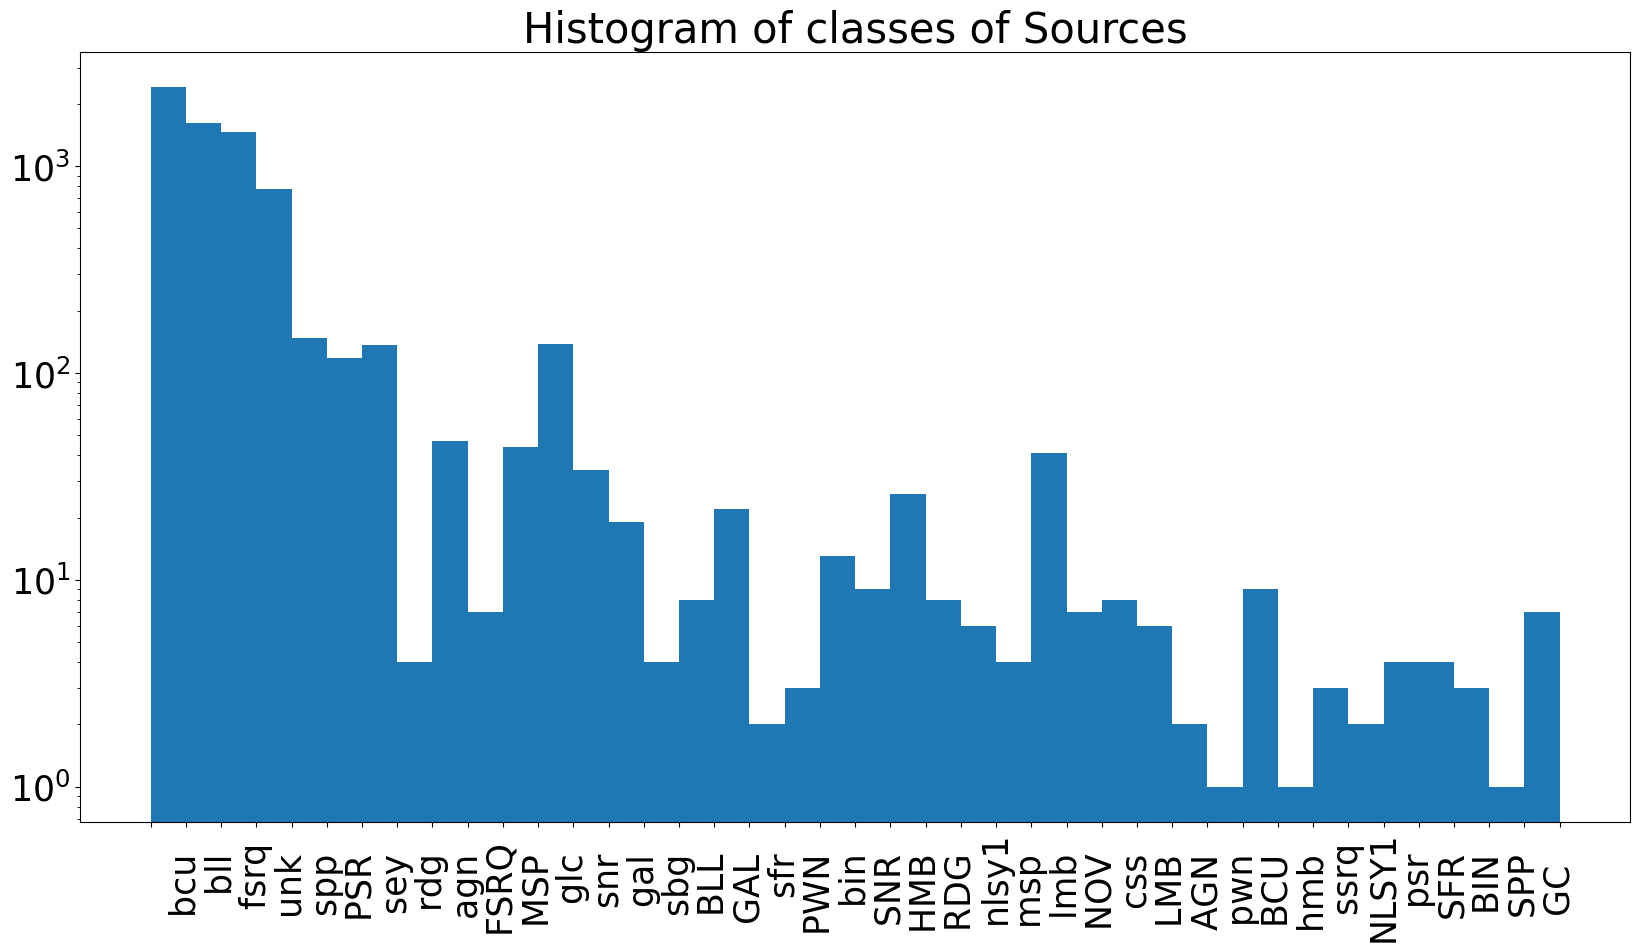

In [7]:
# Plot to see distribution of data in the 4FGL Catalog 

fig, ax = plt.subplots(1,1, figsize=(20,10))

ax.hist(cat_4fgl_dr4_data['CLASS1'],bins=40)
ax.tick_params(axis='x', labelrotation=90)
ax.set_yscale("log")
plt.title("Histogram of classes of Sources")

In [8]:
# To get Column labels uncomment below:
#cat_4fgl_dr4_data.dtype

#### Add Fermi LC repo data
Now Get the Fermi LC repo data and keep only sources that exist in both!
For this study we dont divide into sub samples, as we are testing the population as a whole but each source with its past data.
Later the ML code can be improved to add more parameters based on the subclass of the source to see if predictions can get better.

In [9]:
n_sources = len(cat_4fgl_dr4_data)
print("Total number of sources used ",n_sources)

Total number of sources used  7195


Note that: The LCR provides light curves for all sources in the 4FGL-DR2 catalog that exhibit a variability index greater than 21.67, where the variability index can be thought of as a proxy to the average fractional variability with dF/F measured on timescales of 1 year. As defined in the 4FGL-DR2 catalog, sources with a variability index greater than 21.67 over 12 intervals are estimated to have a < 1% chance of being a steady source. (From https://fermi.gsfc.nasa.gov/ssc/data/access/lat/LightCurveRepository/about.html)

## Data Download:
This can be skipped after the initial run

In [10]:
os.getcwd()

'/Users/aadesai1/Desktop/In_use/ML_work/Fermi_amego_alert_project/Main/Fermi_Sample'

In [11]:
skipped_sources=0
for indi_i in range(len(cat_4fgl_dr4_data)):
    name_tested = cat_4fgl_dr4_data[indi_i][0][:-1].decode('UTF-8')
    if os.path.isfile(f'../../data_fermi_LC_from_lc_repo/saved_lc_4FGL_{name_tested[-12:]}.pickle')==False:
        data_loaded = pyLCR.getLightCurve(name_tested, cadence='weekly', flux_type='photon', index_type='free', ts_min=4)
        try:
            loaded_arr = get_infor_from_fermi_lc(data_loaded)
        except:
            print(f'{name_tested} not found in LCR')
            skipped_sources+=1
            continue
        else:
            print(f'Found {name_tested}!')
        
    
        with open(f'../../data_fermi_LC_from_lc_repo/saved_lc_4FGL_{data_loaded.source[-12:]}.pickle', 'wb') as handle:
            pickle.dump(loaded_arr, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(f'{data_loaded.source[-12:]} printed on Pickle File')
    else:
        print(f'\n {name_tested[-12:]} existing')
print(f'Skipped {skipped_sources} sources out of {n_sources}')


Error: 4FGL J0000.3-7355 is not a source that is tracked by the LCR.
4FGL J0000.3-7355 not found in LCR

Error: 4FGL J0000.5+0743 is not a source that is tracked by the LCR.
4FGL J0000.5+0743 not found in LCR

Error: 4FGL J0000.7+2530 is not a source that is tracked by the LCR.
4FGL J0000.7+2530 not found in LCR

Error: 4FGL J0001.2+4741 is not a source that is tracked by the LCR.
4FGL J0001.2+4741 not found in LCR

 J0001.2-0747 existing

Error: 4FGL J0001.4-0010 is not a source that is tracked by the LCR.
4FGL J0001.4-0010 not found in LCR

 J0001.5+2113 existing

Error: 4FGL J0001.6+3503 is not a source that is tracked by the LCR.
4FGL J0001.6+3503 not found in LCR

Error: 4FGL J0001.6-4156 is not a source that is tracked by the LCR.
4FGL J0001.6-4156 not found in LCR

Error: 4FGL J0001.8-2153 is not a source that is tracked by the LCR.
4FGL J0001.8-2153 not found in LCR

Error: 4FGL J0002.1-6728 is not a source that is tracked by the LCR.
4FGL J0002.1-6728 not found in LCR

Error:

In [12]:
print("Done")
print("Total number of sources ran: ",n_sources-skipped_sources)

Done
Total number of sources ran:  1500


# First Derive the flux at ~1 MeV for all sources

This is done by:
- 1. Assuming that the best fit spectrum for the one is what is reported in the catalog
- 2. Using the peak flux and peak enegy along with the spectrum interpolate it to 1 MeV


In [13]:
def spectral_model(spectrumtype,parameters,x):
    # Logic is that the Model goes like Flux (dn/de) = model()
    # Flux(x)/Flux(pivot_energy) = model(x)/model(pivot_energy)
    if spectrumtype=='LogParabola':
        pivot_eng =  parameters[0] #N
        pivot_flux = parameters[1] #E0
        alpha = parameters[2]
        beta =  parameters[3]
        # y = N * (x/eb)**(-alpha+beta*np.log(x/eb))
        y = pivot_flux*((x/pivot_eng)**(-alpha+beta*np.log(x/pivot_eng)))
        return y
    elif spectrumtype=='PLSuperExpCutoff':
        pivot_eng =  parameters[0]
        pivot_flux = parameters[1]
        index1 =     -1*parameters[2]
        expfactor =  parameters[3]
        index2 =     parameters[4]
        # y = N * (x**index1)*np.exp(-expfactor*(pivot_eng**index2-x**index2))
        y = pivot_flux*((x/pivot_eng)**index1)*np.exp(-expfactor*(pivot_eng**index2-x**index2))
        return y
    elif spectrumtype=='PowerLaw':
        pivot_eng =  parameters[0]
        pivot_flux = parameters[1]
        index =      parameters[2]
        # y = N * (x**index1)
        y = pivot_flux*((x/pivot_eng)**index)
        return y
    else:
        y = -1
        return y
        
        

In [14]:
flux_at_100_mev = []

for i in range(len(cat_4fgl_dr4_data['SpectrumType'])):
    energy_calc = 100 #MeV
    if cat_4fgl_dr4_data['SpectrumType'][i]==b'LogParabola      ':
        parameters_arr = [cat_4fgl_dr4_data['Pivot_Energy'][i],\
                         cat_4fgl_dr4_data['LP_Flux_Density'][i],\
                         cat_4fgl_dr4_data['LP_Index'][i],\
                         cat_4fgl_dr4_data['LP_beta'][i]]
        y1 = spectral_model('LogParabola',parameters_arr,energy_calc)
    elif cat_4fgl_dr4_data['SpectrumType'][i]==b'PLSuperExpCutoff ':
        parameters_arr = [cat_4fgl_dr4_data['Pivot_Energy'][i],\
                         cat_4fgl_dr4_data['PLEC_Flux_Density'][i],\
                         cat_4fgl_dr4_data['PLEC_IndexS'][i],\
                         cat_4fgl_dr4_data['PLEC_ExpfactorS'][i],\
                         cat_4fgl_dr4_data['PLEC_Exp_Index'][i]]
        y1 = spectral_model('PLSuperExpCutoff',parameters_arr,energy_calc)
    elif cat_4fgl_dr4_data['SpectrumType'][i]==b'PowerLaw         ':
        parameters_arr = [cat_4fgl_dr4_data['Pivot_Energy'][i],\
                         cat_4fgl_dr4_data['PL_Flux_Density'][i],\
                         cat_4fgl_dr4_data['PL_Index'][i]]
        y1 = spectral_model('PowerLaw',parameters_arr,energy_calc)
    else:
        print("ERROR: SPECTRUM NOT FOUND!!!! for ",i,f'---> {cat_4fgl_dr4_data["SpectrumType"][i]}')
    flux_at_100_mev.append(y1)
    del y1
# No error means all the spectra are loaded!

print(np.amin(flux_at_100_mev))
# If you get -1 then spectrum is not loaded properly in definition somehow

0.0


In [15]:
def get_y_from_energy(energy_calc,catalog_index):
    if cat_4fgl_dr4_data['SpectrumType'][catalog_index]==b'LogParabola      ':
        parameters_arr = [cat_4fgl_dr4_data['Pivot_Energy'][catalog_index],\
                         cat_4fgl_dr4_data['LP_Flux_Density'][catalog_index],\
                         cat_4fgl_dr4_data['LP_Index'][catalog_index],\
                         cat_4fgl_dr4_data['LP_beta'][catalog_index]]
        y_res = spectral_model('LogParabola',parameters_arr,energy_calc)
    elif cat_4fgl_dr4_data['SpectrumType'][catalog_index]==b'PLSuperExpCutoff ':
        parameters_arr = [cat_4fgl_dr4_data['Pivot_Energy'][catalog_index],\
                         cat_4fgl_dr4_data['PLEC_Flux_Density'][catalog_index],\
                         cat_4fgl_dr4_data['PLEC_IndexS'][catalog_index],\
                         cat_4fgl_dr4_data['PLEC_ExpfactorS'][catalog_index],\
                         cat_4fgl_dr4_data['PLEC_Exp_Index'][catalog_index]]
        y_res = spectral_model('PLSuperExpCutoff',parameters_arr,energy_calc)
    elif cat_4fgl_dr4_data['SpectrumType'][catalog_index]==b'PowerLaw         ':
        parameters_arr = [cat_4fgl_dr4_data['Pivot_Energy'][catalog_index],\
                         cat_4fgl_dr4_data['PL_Flux_Density'][catalog_index],\
                         cat_4fgl_dr4_data['PL_Index'][catalog_index]]
        y_res = spectral_model('PowerLaw',parameters_arr,energy_calc)
    else:
        print("ERROR: SPECTRUM NOT FOUND!!!! for ",i,f'---> {cat_4fgl_dr4_data["SpectrumType"][catalog_index]}')

    return y_res

In [16]:
integrated_flux_vals = []
for i in range(len(cat_4fgl_dr4_data['SpectrumType'])):
    flux_arr= []
    for e_val in [0.1,0.5,1,5,10,50,100,500]:
        y_val = get_y_from_energy(e_val,i)
        if y_val<=1e-20 or y_val>=1e4:
            y_val=0
        flux_arr.append(y_val)
    integrated_flux_vals.append(flux_arr)
    
# No error means all the spectra are loaded!


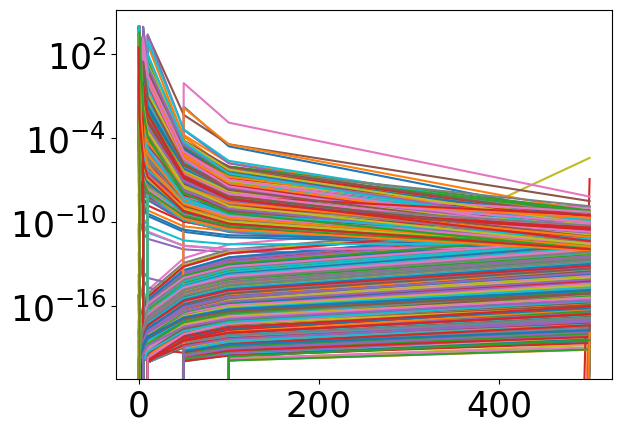

In [17]:
for i in range(len(integrated_flux_vals)):
    plt.plot([0.1,0.5,1,5,10,50,100,500],integrated_flux_vals[i])
    plt.yscale("log")

In [18]:
# Make Aitoff plot to see how this looks like at different energies,
# and use AMEGO sensitivity to see how much will be seen.....


#for i in range(len(cat_4fgl_dr4_data['SpectrumType'])):

In [19]:
# Setup for Aitoff from SNUGGY
"""
gal_coords1 = arr[2]
ra = gal_coords1.l.wrap_at(180 * u.deg).radian
dec = gal_coords1.b.wrap_at(180 * u.deg).radian#z_list = arr_with_flux[1]/sum(arr_with_flux[1])
z_list = 10**arr_with_flux[1]
z_list=z_list/sum(z_list)

coords = gal_coords1


fig = plt.figure(figsize=(20,10),dpi=250)
ax= fig.add_subplot(111, projection='aitoff')
ax.set_facecolor("Ivory")
image = plt.scatter(coords.l.wrap_at('180d').radian, coords.b.radian, c=z_list, cmap='plasma', norm=colors.LogNorm(vmax=np.nanmax(z_list)))
#plt.legend(loc="lower right")

plt.xlabel('l')
plt.ylabel('b.')
plt.grid(True)
plt.colorbar(image, spacing='uniform',label="Neutrino Flux",ticks=[0,1])
"""

'\ngal_coords1 = arr[2]\nra = gal_coords1.l.wrap_at(180 * u.deg).radian\ndec = gal_coords1.b.wrap_at(180 * u.deg).radian#z_list = arr_with_flux[1]/sum(arr_with_flux[1])\nz_list = 10**arr_with_flux[1]\nz_list=z_list/sum(z_list)\n\ncoords = gal_coords1\n\n\nfig = plt.figure(figsize=(20,10),dpi=250)\nax= fig.add_subplot(111, projection=\'aitoff\')\nax.set_facecolor("Ivory")\nimage = plt.scatter(coords.l.wrap_at(\'180d\').radian, coords.b.radian, c=z_list, cmap=\'plasma\', norm=colors.LogNorm(vmax=np.nanmax(z_list)))\n#plt.legend(loc="lower right")\n\nplt.xlabel(\'l\')\nplt.ylabel(\'b.\')\nplt.grid(True)\nplt.colorbar(image, spacing=\'uniform\',label="Neutrino Flux",ticks=[0,1])\n'

In [20]:
# Check

"""fsrq_4fgl_indices = []
ts_4fgl_fsrq_300_1000 = []
for i in range(len(cat_4fgl_dr3_data['CLASS1'])):
    if cat_4fgl_dr3_data['CLASS1'][i]==b'fsrq ' or cat_4fgl_dr3_data['CLASS1'][i]==b'FSRQ ':
        fsrq_4fgl_indices.append(i)
        if cat_4fgl_dr3_data['Sqrt_TS_Band'][:,3][i]==np.amin(cat_4fgl_dr3_data['Sqrt_TS_Band'][:,3]):
            ts_4fgl_fsrq_300_1000.append(0.0)
        else:
            ts_4fgl_fsrq_300_1000.append(cat_4fgl_dr3_data['Sqrt_TS_Band'][:,3][i])
    else:
        #print(cat_4fgl_dr3_data['CLASS1'][i])
        continue
print(len(fsrq_4fgl_indices))

bll_4fgl_indices = []
ts_4fgl_bll_300_1000 = []
for i in range(len(cat_4fgl_dr3_data['CLASS1'])):
    if cat_4fgl_dr3_data['CLASS1'][i]==b'bll  ' or cat_4fgl_dr3_data['CLASS1'][i]==b'BLL  ':
        bll_4fgl_indices.append(i)
        if cat_4fgl_dr3_data['Sqrt_TS_Band'][:,3][i]==np.amin(cat_4fgl_dr3_data['Sqrt_TS_Band'][:,3]):
            ts_4fgl_bll_300_1000.append(0.0)
        else:
            ts_4fgl_bll_300_1000.append(cat_4fgl_dr3_data['Sqrt_TS_Band'][:,3][i])
    else:
        #print(cat_4fgl_dr3_data['CLASS1'][i])
        continue
print(len(bll_4fgl_indices))"""

"fsrq_4fgl_indices = []\nts_4fgl_fsrq_300_1000 = []\nfor i in range(len(cat_4fgl_dr3_data['CLASS1'])):\n    if cat_4fgl_dr3_data['CLASS1'][i]==b'fsrq ' or cat_4fgl_dr3_data['CLASS1'][i]==b'FSRQ ':\n        fsrq_4fgl_indices.append(i)\n        if cat_4fgl_dr3_data['Sqrt_TS_Band'][:,3][i]==np.amin(cat_4fgl_dr3_data['Sqrt_TS_Band'][:,3]):\n            ts_4fgl_fsrq_300_1000.append(0.0)\n        else:\n            ts_4fgl_fsrq_300_1000.append(cat_4fgl_dr3_data['Sqrt_TS_Band'][:,3][i])\n    else:\n        #print(cat_4fgl_dr3_data['CLASS1'][i])\n        continue\nprint(len(fsrq_4fgl_indices))\n\nbll_4fgl_indices = []\nts_4fgl_bll_300_1000 = []\nfor i in range(len(cat_4fgl_dr3_data['CLASS1'])):\n    if cat_4fgl_dr3_data['CLASS1'][i]==b'bll  ' or cat_4fgl_dr3_data['CLASS1'][i]==b'BLL  ':\n        bll_4fgl_indices.append(i)\n        if cat_4fgl_dr3_data['Sqrt_TS_Band'][:,3][i]==np.amin(cat_4fgl_dr3_data['Sqrt_TS_Band'][:,3]):\n            ts_4fgl_bll_300_1000.append(0.0)\n        else:\n        